# Updrafts and precipitation-driven downdrafts: standard idealised soundings

Thomas Schanzer  
February 2022

In this notebook, we apply our analysis of updraft and precipitation-driven downdraft strength at different entrainment rates and initiation levels to standard reference soundings that are free of experimental artifacts or noise.

We explore the changes in our results when the soundings are made warmer, preserving relative humidity and CAPE (we use our own implementation that uses the virtual temperature correction). Rather than simply adding 5 K to the temperature profile, we first compute the profiles of the original surface parcel and one whose initial temperature is 5 K warmer (with the same RH), then shift the virtual temperature profile such that the virtual temperature difference between the new environmental and parcel profiles is the same at every level as in the original sounding. This should ensure that the CAPE is unchanged.

In [1]:
import sys
import shelve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.signal import argrelmin
from scipy.integrate import simpson

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import metpy.constants as const

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)

sys.path.append('../convection_scheme')
from coupler import CoupledThermalGenerator

In [17]:
# fixed parameters
thickness = 2*units.km
t_pert = 1*units.delta_degC
l_crit = 2e-3*units.dimensionless
drag_up, drag_down = 0/units.km, 0/units.km
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.02)*(1/units.km)
epsilon_up = [0.1, 0.3, 0.5]*(1/units.km)
dnu_db = 0*units.second**2/units.meter**2

## Helper functions

In [18]:
def downdraft_init_levels(generator, thickness):
    """Get initiation and precipitation top levels for downdrafts."""
    i_init_down_min = np.min(np.argwhere(generator.height <= 4000*units.meter))
    i_init_down_max = np.max(np.argwhere(generator.height >= 500*units.meter))
    i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
    z_init_down = generator.height[i_init_down_min:i_init_down_max+1:2]
    i_precip_top = np.argmin(np.abs(
        np.atleast_2d(generator.height)
        - np.atleast_2d(z_init_down + thickness).T
    ), axis=1)
    return i_init_down, z_init_down, i_precip_top

In [19]:
def run_updraft(generator, t_pert, l_crit, epsilon_up, drag_up):
    """Run the updraft calculation."""
    i_init_up = generator.pressure.size - 1
    q_pert = (
        saturation_specific_humidity(
            generator.pressure[i_init_up], generator.temperature[i_init_up])
         - generator.specific_humidity[i_init_up]
    )/1.5
    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        epsilon_up, dnu_db, drag_up, l_crit, basic=True)
    return updraft

In [20]:
def get_total_precip(updraft, i_init_down, i_precip_top):
    """Calculate total precipitation."""
    total_precip = np.zeros(len(i_init_down))*units('')
    for i in range(len(i_init_down)):
        total_precip[i] = np.nansum((
            updraft.precipitation*updraft.m_remaining
        )[i_precip_top[i] : i_init_down[i] + 1])
    return total_precip

In [21]:
def run_downdrafts(generator, i_init_down, total_precip, drag_down):
    """Run the downdraft calculations."""
    downdrafts = np.zeros((len(i_init_down), epsilon_down.size),
                          dtype='object')
    n_calc = epsilon_down.size*len(i_init_down)
    n_done = 0
    for i in range(len(i_init_down)):
        for j in range(epsilon_down.size):
            n_done += 1
            sys.stdout.write(f'\r        Calculation {n_done} of {n_calc}    ')
            downdrafts[i,j] = generator.precipitation_downdraft(
                i_init_down[i], total_precip[i], w_initial,
                epsilon_down[j], dnu_db, drag_down, basic=True)
    sys.stdout.write('\n')
    return downdrafts

In [22]:
def get_downdraft_data(generator, downdrafts):
    """Find max downdraft velocity and min height."""
    max_velocity = np.zeros(downdrafts.shape)*units('m/s')
    max_velocity_height = np.zeros(downdrafts.shape)*units.meter
    min_height = np.zeros(downdrafts.shape)*units.meter

    for i in range(downdrafts.shape[0]):
        for j in range(downdrafts.shape[1]):
            max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
            max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
            max_velocity_height[i,j] = generator.height[max_velocity_i]
            min_height_i = np.max(
                np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
            min_height[i,j] = generator.height[min_height_i]
            
    return max_velocity, max_velocity_height, min_height

In [23]:
def multiple_downdraft_runs(
        generator, name, thickness, t_pert, l_crit, drag_up, drag_down):
    """Do a downdraft run for each updraft entrainment rate."""
    print('Starting run ' + name + ' ...')
    
    (i_init_down,
     z_init_down,
     i_precip_top) = downdraft_init_levels(generator, thickness)
    theta_e = equivalent_potential_temperature(
        generator.pressure, generator.temperature, generator.specific_humidity)
    z_min_theta_e = generator.height[np.argmin(theta_e)]
    
    w_max_all = []
    z_w_max_all = []
    z_min_all = []
    z_max_evap_all = []
    
    for eps in epsilon_up:
        print('    epsilon_up = {:.2f} /km ...'.format(eps.m))
        updraft = run_updraft(generator, t_pert, l_crit, eps, drag_up)
        total_precip = get_total_precip(updraft, i_init_down, i_precip_top)
        downdrafts = run_downdrafts(
            generator, i_init_down, total_precip, drag_down)
        w_max, z_w_max, z_min = get_downdraft_data(generator, downdrafts)
        z_max_evap = z_init_down[np.argmax(total_precip, axis=0)]
        
        w_max_all.append(w_max)
        z_w_max_all.append(z_w_max)
        z_min_all.append(z_min)
        z_max_evap_all.append(z_max_evap)
        
    with shelve.open('generalising_coupling_data/' + name) as db:
        db['z_init_down'] = z_init_down
        db['z_min_theta_e'] = z_min_theta_e
        db['z_max_evap'] = z_max_evap_all
        db['w_max'] = w_max_all
        db['z_w_max'] = z_w_max_all
        db['z_min'] = z_min_all

In [24]:
def cape_virtual(pressure, height, temperature, dewpoint):
    """
    Calculates CAPE with the virtual temperature correction.
    
    Args:
        pressure: Pressure profile.
        height: Height of each pressure level.
        temperature: Temperature profile (initial parcel temperature is
            temperature[0]).
        dewpoint: Dew point profile (initial parcel dew point is
            dewpoint[0]).
            
    Returns:
        CAPE for the parcel.
    """
    t_parcel = mpcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
    p_lcl, _ = mpcalc.lcl(pressure[0], temperature[0], dewpoint[0])
    q_dry = mpcalc.specific_humidity_from_dewpoint(pressure[0], dewpoint[0])
    q_moist = saturation_specific_humidity(pressure, t_parcel)
    q_parcel = np.where(pressure >= p_lcl, q_dry, q_moist)
    r_parcel = mpcalc.mixing_ratio_from_specific_humidity(q_parcel)
    tv_parcel = mpcalc.virtual_temperature(t_parcel, r_parcel)
    # the approximations used cause the virtual temperature to blow up
    # at low temperatures/pressures so we replace it with the ordinary
    # temperature when it is below 30 C
    # tv_parcel = np.where(t_parcel > -30*units.celsius, tv_parcel, t_parcel)
    
    q_env = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
    r_env = mpcalc.mixing_ratio_from_specific_humidity(q_env)
    tv_env = mpcalc.virtual_temperature(temperature, r_env)
    # tv_env = np.where(temperature > -30*units.celsius, tv_env, temperature)
    
    buoyancy = (
        (tv_parcel.to(units.kelvin) - tv_env.to(units.kelvin))
        / tv_env.to(units.kelvin)*const.g
    )
    b_orig = (t_parcel - temperature)/temperature*const.g
    b_positive = np.maximum(buoyancy, 0)
    cape = simpson(b_positive.m_as(units('m/s^2')), height.m_as(units.meter))

    return cape*units('J/kg')

In [25]:
def dtv_dt(p, t, rh):
    r = mpcalc.mixing_ratio_from_relative_humidity(p, t, rh)
    tv = mpcalc.virtual_temperature(t, r)
    
    a = 17.67
    b = 243.5*units.kelvin
    e0 = 6.112*units.mbar
    c = 273.15*units.kelvin
    es = mpcalc.saturation_vapor_pressure(t)
    des_dt = a*b*es/(t - c + b)**2
    dr_dt = rh*(const.epsilon*p/(p - const.epsilon*es)**2)*des_dt
    return tv, ((r + const.epsilon)/(const.epsilon*(1 + r))
                 + t*dr_dt*((1 + const.epsilon)/(const.epsilon*(1 + r)**2)))

## The McClatchey (1972) tropical sounding

In [29]:
file = 'test_soundings/mcclatchey_tropical.csv'
sounding = pd.read_csv(file).to_numpy()
height_raw = sounding[:,0]
pressure_raw = sounding[:,1]
temperature_raw = sounding[:,2]
density = sounding[:,3]
vapour = sounding[:,4]
specific_humidity_raw = vapour/density

pressure = np.arange(pressure_raw[0], pressure_raw[-1], -5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*1e3*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.kelvin
specific_humidity = interp1d(
    pressure_raw, specific_humidity_raw)(pressure)*units.dimensionless
dewpoint = mpcalc.dewpoint_from_specific_humidity(
    pressure, temperature, specific_humidity)

mcclatchey = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(temperature),
    np.flip(specific_humidity))

In [63]:
original_profile = mpcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
p_lcl, _ = mpcalc.lcl(pressure[0], temperature[0], dewpoint[0])
q_dry = mpcalc.specific_humidity_from_dewpoint(pressure[0], dewpoint[0])
q_moist = saturation_specific_humidity(pressure, original_profile)
q_parcel = np.where(pressure >= p_lcl, q_dry, q_moist)
r_parcel = mpcalc.mixing_ratio_from_specific_humidity(q_parcel)
tv_parcel_orig = mpcalc.virtual_temperature(original_profile, r_parcel)

r_env = mpcalc.mixing_ratio_from_specific_humidity(specific_humidity)
tv_env_orig = mpcalc.virtual_temperature(temperature, r_env)

t_sfc_new = temperature[0] + 5*units.delta_degC
rh_orig = mpcalc.relative_humidity_from_dewpoint(temperature, dewpoint)
td_sfc_new = mpcalc.dewpoint_from_relative_humidity(t_sfc_new, rh_orig[0])

new_profile = mpcalc.parcel_profile(pressure, t_sfc_new, td_sfc_new)
p_lcl, _ = mpcalc.lcl(pressure[0], t_sfc_new, td_sfc_new)
q_dry = mpcalc.specific_humidity_from_dewpoint(pressure[0], td_sfc_new)
q_moist = saturation_specific_humidity(pressure, new_profile)
q_parcel = np.where(pressure >= p_lcl, q_dry, q_moist)
r_parcel = mpcalc.mixing_ratio_from_specific_humidity(q_parcel)
tv_parcel_new = mpcalc.virtual_temperature(new_profile, r_parcel)

tv_env_new = (tv_env_orig.to(units.kelvin)
              + tv_parcel_new.to(units.kelvin)
              - tv_parcel_orig.to(units.kelvin))
new_temperature = (temperature.to(units.kelvin)
                   + new_profile.to(units.kelvin)
                   - original_profile.to(units.kelvin))
for _ in range(10):
    value, slope = dtv_dt(pressure, new_temperature, rh_orig)
    new_temperature -= (value - tv_env_new)/slope

new_dewpoint = mpcalc.dewpoint_from_relative_humidity(new_temperature, rh_orig)

original_cape = cape_virtual(pressure, height, temperature, dewpoint)
print('Original CAPE:', original_cape)
new_cape = cape_virtual(pressure, height, new_temperature, new_dewpoint)
print('New CAPE:', new_cape)
print('Difference:', ((original_cape - new_cape)/original_cape*100).m, '%')

new_specific_humidity = mpcalc.specific_humidity_from_dewpoint(
    pressure, new_dewpoint)
mcclatchey_warmer = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(new_temperature),
    np.flip(new_specific_humidity))

Original CAPE: 1421.0979621074528 joule / kilogram
New CAPE: 1358.0520473536124 joule / kilogram
Difference: 4.436422852956942 %


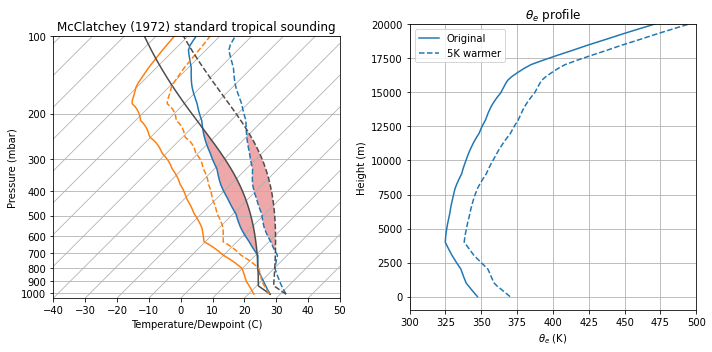

In [59]:
fig = plt.figure(figsize=(10,5))

skew = SkewT(fig, subplot=(1, 2, 1), rotation=45)
skew.plot(pressure, temperature)
skew.plot(pressure, dewpoint)
profile = mpcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
skew.plot(pressure, profile, '0.3')
skew.shade_cape(pressure, temperature, profile)

skew.ax.set_prop_cycle(None)
skew.plot(pressure, new_temperature, '--')
skew.plot(pressure, new_dewpoint, '--')
profile = mpcalc.parcel_profile(pressure, new_temperature[0], new_dewpoint[0])
skew.plot(pressure, new_profile, '--', color='0.3')
skew.shade_cape(pressure, new_temperature, profile)

skew.ax.set(xlabel='Temperature/Dewpoint (C)', ylabel='Pressure (mbar)',
            title='McClatchey (1972) standard tropical sounding')

ax = fig.add_subplot(122)
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)
new_theta_e = equivalent_potential_temperature(
    pressure, new_temperature, new_specific_humidity)
ax.plot(theta_e, height, label='Original')
ax.plot(new_theta_e, height, '--', color='tab:blue', label='5K warmer')
ax.grid()
ax.set_ylim(-1000, 20000)
ax.set_xlim(300, 500)
ax.set(xlabel='$\\theta_e$ (K)', ylabel='Height (m)',
       title='$\\theta_e$ profile')
ax.legend()

fig.tight_layout()

In [31]:
updrafts_orig = np.empty(epsilon_up.size, dtype='object')
updrafts_warm = np.empty(epsilon_up.size, dtype='object')
for i, eps in enumerate(epsilon_up):
    updrafts_orig[i] = run_updraft(
        mcclatchey, t_pert, l_crit, eps, drag_up)
    updrafts_warm[i] = run_updraft(
        mcclatchey_warmer, t_pert, l_crit, eps, drag_up)

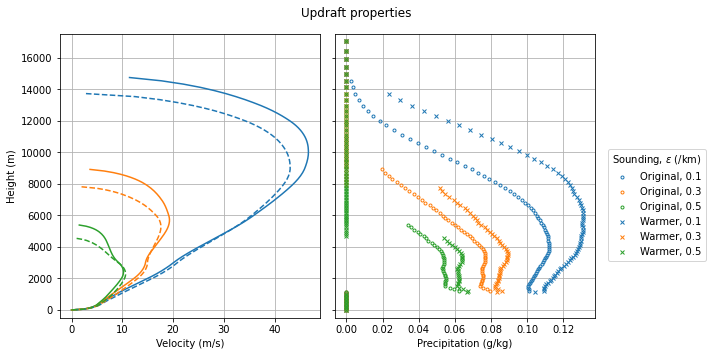

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
for eps, updraft in zip(epsilon_up, updrafts_orig):
    ax1.plot(updraft.velocity, mcclatchey.height,
            label='Original, {:.1f}'.format(eps.m))
    ax2.plot(updraft.precipitation[::2]*1e3, mcclatchey.height[::2], 'o', markersize=3,
            fillstyle='none', label='Original, {:.1f}'.format(eps.m))
ax1.set_prop_cycle(None)
ax2.set_prop_cycle(None)
for eps, updraft in zip(epsilon_up, updrafts_warm):
    ax1.plot(updraft.velocity, mcclatchey.height, '--',
            label='Warmer, {:.1f}'.format(eps.m))
    ax2.plot(updraft.precipitation[::2]*1e3, mcclatchey.height[::2], 'x', markersize=4,
            label='Warmer, {:.1f}'.format(eps.m))
ax1.grid()
ax2.grid()
ax1.set_ylim(-500, 17500)
ax2.set_ylim(-500, 17500)
ax2.set_ylabel('')
ax2.set_yticklabels([])
ax2.legend(loc=(1.05,0.2), title='Sounding, $\\epsilon$ (/km)')
ax1.set(xlabel='Velocity (m/s)', ylabel='Height (m)')
ax2.set_xlabel('Precipitation (g/kg)')
fig.suptitle('Updraft properties')
fig.tight_layout()

In [45]:
%%time
multiple_downdraft_runs(
    mcclatchey, 'mcclatchey_tropical',
    thickness, t_pert, l_crit, drag_up, drag_down)

Starting run mcclatchey ...
    epsilon_up = 0.10 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.30 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.50 /km ...
        Calculation 924 of 924    
CPU times: user 8min 16s, sys: 6.21 s, total: 8min 22s
Wall time: 8min 27s


In [46]:
%%time
multiple_downdraft_runs(
    mcclatchey_warmer, 'mcclatchey_tropical_5K_warmer_same_CAPE_virtual',
    thickness, t_pert, l_crit, drag_up, drag_down)

Starting run mcclatchey_5K_warmer_same_CAPE_virtual ...
    epsilon_up = 0.10 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.30 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.50 /km ...
        Calculation 924 of 924    
CPU times: user 8min 16s, sys: 6.34 s, total: 8min 23s
Wall time: 8min 28s


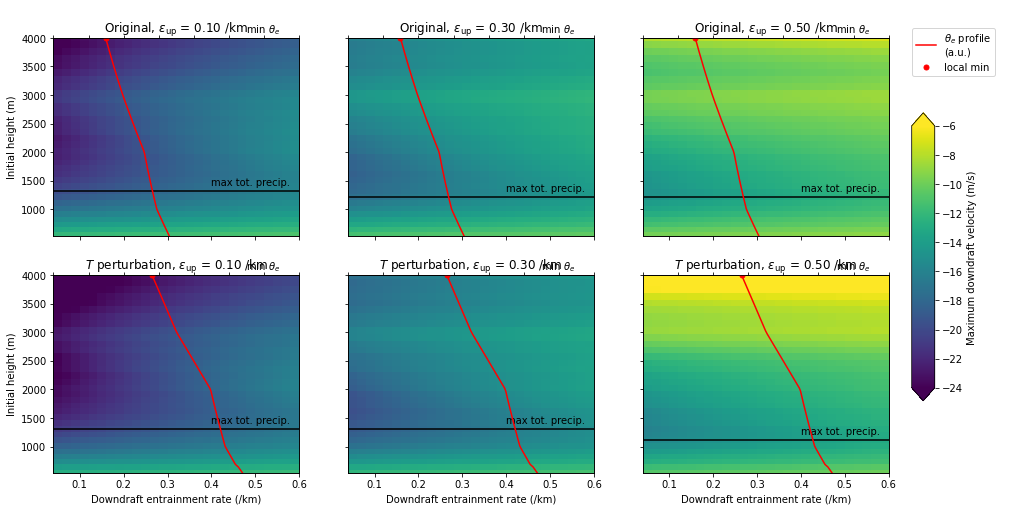

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for i, name in enumerate(
        ['mcclatchey_tropical', 'mcclatchey_tropical_5K_warmer_same_CAPE_virtual']):
    db = shelve.open('generalising_coupling_data/' + name)
    sounding = {'mcclatchey_tropical': mcclatchey,
                'mcclatchey_tropical_5K_warmer_same_CAPE_virtual': mcclatchey_warmer}[name]
    theta_e = equivalent_potential_temperature(
        sounding.pressure, sounding.temperature, sounding.specific_humidity)
    i_relmin_theta_e = argrelmin(theta_e, order=4)
    for j, eps in enumerate(epsilon_up):
        mesh = axes[i,j].pcolormesh(
            epsilon_down, db['z_init_down'], db['w_max'][j], shading='nearest')
        mesh.set_clim(-24, -6)
        
        axes[i,j].axhline(db['z_max_evap'][j].m, color='k')
        axes[i,j].text(0.4, db['z_max_evap'][j].m + 100, 'max tot. precip.')
        axes[i,j].axhline(db['z_min_theta_e'].m, color='k',
                          label='min $\\theta_e$')
        axes[i,j].text(0.48, db['z_min_theta_e'].m + 100,
                       'min $\\theta_e$', color='k')
        
        ax = axes[i,j].twiny()
        ax.plot(theta_e, sounding.height,
                label='$\\theta_e$ profile\n(a.u.)', color='r')
        ax.plot(theta_e[i_relmin_theta_e], sounding.height[i_relmin_theta_e],
                'r.', markersize=10, label='local min')
        ax.set_xlim(310, 380)
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
        title = ({'mcclatchey_tropical': 'Original',
                  'mcclatchey_tropical_5K_warmer_same_CAPE_virtual': '$T$ perturbation'}[name]
                 + ', $\\epsilon_\\mathrm{{up}}$ = {:.2f} /km'.format(eps.m))
        axes[i,j].set(xlabel='Downdraft entrainment rate (/km)',
                      ylabel='Initial height (m)',
                      title=title)
        axes[i,j].set_ylim(540, 4000)
    db.close()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.89, 0.85))
    
for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.25, 0.02, 0.5])
cbar = fig.colorbar(mesh, cax=cbar_ax, extend='both')
cbar.set_label('Maximum downdraft velocity (m/s)')

# fig.tight_layout()

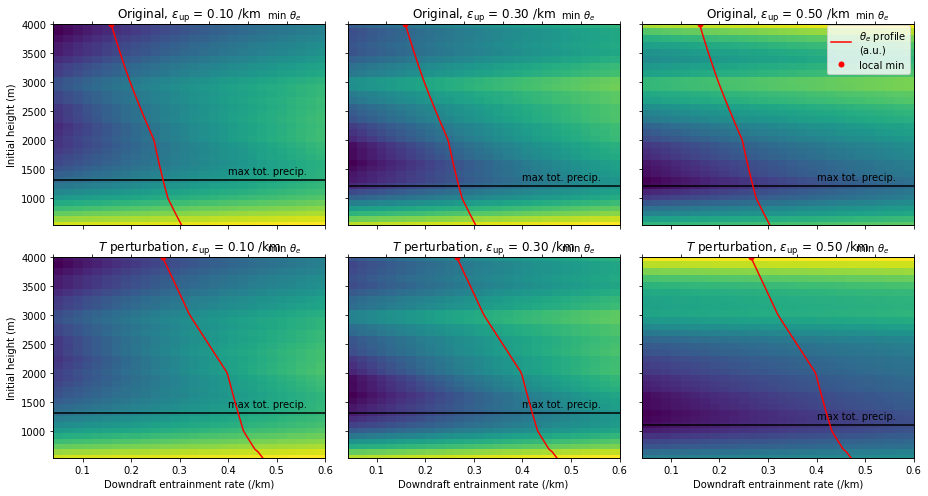

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(13, 7))

for i, name in enumerate(
        ['mcclatchey_tropical', 'mcclatchey_tropical_5K_warmer_same_CAPE_virtual']):
    db = shelve.open('generalising_coupling_data/' + name)
    sounding = {'mcclatchey_tropical': mcclatchey,
                'mcclatchey_tropical_5K_warmer_same_CAPE_virtual': mcclatchey_warmer}[name]
    theta_e = equivalent_potential_temperature(
        sounding.pressure, sounding.temperature, sounding.specific_humidity)
    i_relmin_theta_e = argrelmin(theta_e, order=4)
    for j, eps in enumerate(epsilon_up):
        mesh = axes[i,j].pcolormesh(
            epsilon_down, db['z_init_down'], db['w_max'][j], shading='nearest')
        # mesh.set_clim(-24, -6)
        
        axes[i,j].axhline(db['z_max_evap'][j].m, color='k')
        axes[i,j].text(0.4, db['z_max_evap'][j].m + 100, 'max tot. precip.')
        axes[i,j].axhline(db['z_min_theta_e'].m, color='k',
                          label='min $\\theta_e$')
        axes[i,j].text(0.48, db['z_min_theta_e'].m + 100,
                       'min $\\theta_e$', color='k')
        
        ax = axes[i,j].twiny()
        ax.plot(theta_e, sounding.height,
                label='$\\theta_e$ profile\n(a.u.)', color='r')
        ax.plot(theta_e[i_relmin_theta_e], sounding.height[i_relmin_theta_e],
                'r.', markersize=10, label='local min')
        ax.set_xlim(310, 380)
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
        title = ({'mcclatchey_tropical': 'Original',
                  'mcclatchey_tropical_5K_warmer_same_CAPE_virtual': '$T$ perturbation'}[name]
                 + ', $\\epsilon_\\mathrm{{up}}$ = {:.2f} /km'.format(eps.m))
        axes[i,j].set(xlabel='Downdraft entrainment rate (/km)',
                      ylabel='Initial height (m)',
                      title=title)
        axes[i,j].set_ylim(540, 4000)
    db.close()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.89, 0.85))
    
for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
fig.tight_layout()

## Discussion
- Again, in a sounding with $\theta_e$ monotonically decreasing on the lowest 4 km, two maxima in downdraft strength are just visible: one near the level of max. precipitation and one higher up.
- The downdrafts are slightly stronger in the warmer sounding due to increased precipitation, and the updrafts are slightly weaker due to the (apparently, despite our efforts) smaller CAPE.